In [1]:
'''Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

# Old model for keras, need to update to tensorflow 2
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import matplotlib.pyplot as plt

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [2]:
# if K.image_data_format() == 'channels_first':
#     x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
#     x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
#     input_shape = (1, img_rows, img_cols)
# else:
#     x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
#     x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
#     input_shape = (img_rows, img_cols, 1)

# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# x_train /= 255
# x_test /= 255
# print('x_train shape:', x_train.shape)
# print(x_train.shape[0], 'train samples')
# print(x_test.shape[0], 'test samples')

# # convert class vectors to binary class matrices
# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)

# model = Sequential()
# model.add(Conv2D(32, kernel_size=(3, 3),
#                  activation='relu',
#                  input_shape=input_shape))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes, activation='softmax'))

# model.compile(loss=keras.losses.categorical_crossentropy,
#               optimizer=keras.optimizers.Adadelta(),
#               metrics=['accuracy'])

# model.fit(x_train, y_train,
#           batch_size=batch_size,
#           epochs=epochs,
#           verbose=1,
#           validation_data=(x_test, y_test))
# score = model.evaluate(x_test, y_test, verbose=0)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

In [10]:
import numpy as np
from tqdm import trange
np.set_printoptions(suppress=True)

# PyTorch model
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.set_printoptions(sci_mode=False)
class ModelNet(torch.nn.Module):
  def __init__(self):
    super(ModelNet, self).__init__()
    self.l1 = nn.Linear(784, 128, bias=False)
    self.l2 = nn.Linear(128, 10, bias=False)
    self.sm = nn.LogSoftmax(dim=1)
  def forward(self, x):
    x = F.relu(self.l1(x))
    x = self.l2(x)
    x = self.sm(x)
    return x
  
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  

loss 0.31 accuracy 0.90: 100%|██████████| 1000/1000 [00:13<00:00, 74.98it/s]


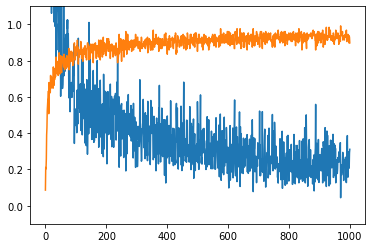

In [49]:
# training
%pylab inline
model = ModelNet()
model.to(torch.device("cuda:0"))

"""
with torch.no_grad():
  model.l1.weight.copy_(torch.tensor(layer_init(784, 128).T))
  model.l2.weight.copy_(torch.tensor(layer_init(128, 10).T))
"""
X_train = x_train
Y_train = y_train
X_test = x_test
Y_test = y_test

loss_function = nn.NLLLoss(reduction='none')
optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)
BS = 128
losses, accuracies = [], []
for i in (t := trange(1000)):
  samp = np.random.randint(0, X_train.shape[0], size=(BS))
  X = torch.tensor(X_train[samp].reshape((-1, 28*28))).float().to(dev)
  # X = torch.tensor(X_train[samp].reshape((-1, 28*28))).float()
  Y = torch.tensor(Y_train[samp]).long().to(dev)
  # Y = torch.tensor(Y_train[samp]).long()
  model.zero_grad()
  out = model(X)
  cat = torch.argmax(out, dim=1)
  accuracy = (cat == Y).float().mean()
  loss = loss_function(out, Y)
  loss = loss.mean()
  loss.backward()
  optim.step()
  loss, accuracy = loss.item(), accuracy.item()
  losses.append(loss)
  accuracies.append(accuracy)
  t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))
plt.ylim(-0.1, 1.1)
plot(losses)
plot(accuracies)

In [50]:
# evaluation
# Y_test_preds = torch.argmax(
#     model(
#         torch.tensor(
#             X_test.reshape(
#                 (-1, 28*28)
#                 ).to(dev).float()), dim=1
#     ).numpy()

# Y_test_preds = model(torch.tensor(X_test.reshape(-1, 28*28)).float().to(dev)).argmax()
# Y_test_preds.cpu().numpy()
# Y_test_preds = torch.argmax(model(torch.tensor(X_test.reshape((-1, 28*28))).float()), dim=1).numpy()
Y_test_preds = torch.argmax(model(torch.tensor(X_test.reshape((-1, 28*28))).float().to(dev)), dim=1).cpu().numpy()
(Y_test == Y_test_preds).mean()

0.9215

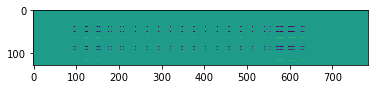

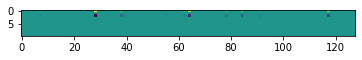

In [6]:
# compute gradients in torch
samp = [0,1,2,3]
model.zero_grad()
out = model(torch.tensor(X_test[samp].reshape((-1, 28*28))).float())
out.retain_grad()
loss = loss_function(out, torch.tensor(Y_test[samp]).long()).mean()
loss.retain_grad()
loss.backward()
imshow(model.l1.weight.grad)
figure()
imshow(model.l2.weight.grad)

In [7]:
# copy weights from pytorch
l1 = model.l1.weight.detach().numpy().T
l2 = model.l2.weight.detach().numpy().T

# numpy forward pass
def forward(x):
  x = x.dot(l1)
  x = np.maximum(x, 0)
  x = x.dot(l2)  
  return x

def numpy_eval():
  Y_test_preds_out = forward(X_test.reshape((-1, 28*28)))
  Y_test_preds = np.argmax(Y_test_preds_out, axis=1)
  return (Y_test == Y_test_preds).mean()

numpy_eval()

0.9308

In [8]:
 numpy forward and backward pass

def logsumexp(x):
  #return np.log(np.exp(x).sum(axis=1))
  # http://gregorygundersen.com/blog/2020/02/09/log-sum-exp/
  c = x.max(axis=1)
  return c + np.log(np.exp(x-c.reshape((-1, 1))).sum(axis=1))

def forward_backward(x, y):
  # training
  out = np.zeros((len(y),10), np.float32)
  out[range(out.shape[0]),y] = 1

  # forward pass
  x_l1 = x.dot(l1)
  x_relu = np.maximum(x_l1, 0)
  x_l2 = x_relu.dot(l2)
  x_lsm = x_l2 - logsumexp(x_l2).reshape((-1, 1))
  x_loss = (-out * x_lsm).mean(axis=1)

  # training in numpy (super hard!)
  # backward pass

  # will involve x_lsm, x_l2, out, d_out and produce dx_sm
  d_out = -out / len(y)

  # derivative of logsoftmax
  # https://github.com/torch/nn/blob/master/lib/THNN/generic/LogSoftMax.c
  dx_lsm = d_out - np.exp(x_lsm)*d_out.sum(axis=1).reshape((-1, 1))

  # derivative of l2
  d_l2 = x_relu.T.dot(dx_lsm)
  dx_relu = dx_lsm.dot(l2.T)

  # derivative of relu
  dx_l1 = (x_relu > 0).astype(np.float32) * dx_relu

  # derivative of l1
  d_l1 = x.T.dot(dx_l1)
  
  return x_loss, x_l2, d_l1, d_l2

samp = [0,1,2,3]
x_loss, x_l2, d_l1, d_l2 = forward_backward(X_test[samp].reshape((-1, 28*28)), Y_test[samp])

imshow(d_l1.T)
figure()
imshow(d_l2.T)

SyntaxError: invalid syntax (<ipython-input-8-9a9b5be0bf1d>, line 1)

In [3]:
# numpy training
def layer_init(m, h):
  # gaussian is strong
  #ret = np.random.randn(m,h)/np.sqrt(m*h)
  # uniform is stronger
  ret = np.random.uniform(-1., 1., size=(m,h))/np.sqrt(m*h)
  return ret.astype(np.float32)

# reinit
np.random.seed(1337)
l1 = layer_init(784, 128)
l2 = layer_init(128, 10)

lr = 0.001
BS = 128
losses, accuracies = [], []
for i in (t := trange(1000)):
  samp = np.random.randint(0, X_train.shape[0], size=(BS))
  X = X_train[samp].reshape((-1, 28*28))
  Y = Y_train[samp]
  x_loss, x_l2, d_l1, d_l2 = forward_backward(X, Y)
  
  cat = np.argmax(x_l2, axis=1)
  accuracy = (cat == Y).mean()
  
  # SGD
  l1 = l1 - lr*d_l1
  l2 = l2 - lr*d_l2
  
  loss = x_loss.mean()
  losses.append(loss)
  accuracies.append(accuracy)
  t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))
  
plt.ylim(-0.1, 1.1)
plot(losses)
plot(accuracies)

NameError: name 'np' is not defined

In [6]:
import tensorflow as tf
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

# with tf.Session() as sess:
#     print (sess.run(c))

In [10]:
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: 


In [9]:
import torch
torch.cuda.is_available()


True